# Style Transfer

Style transfer is a technique where we use two images a style image and a content image. The target image consists of the style that is let's say sort of a background maybe? and the content of the content image is what you would say is the actual content that exist so in a dog image the dog would be the content.

Paper link: https://arxiv.org/abs/1508.06576

In [1]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
from torch.autograd import Variable
import torch.nn as nn


## Set the device to GPU

In [2]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Feature extractor
The core idea of CNN is that they are useful in understanding the structure of image so lower layers could detect edges and higher ones could detect even more complex structure so we use this knowledge for our purpose to extract the content and style of image using pretrained VGG19 network

In [3]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.req_features= ['0','5','10','19','28']
    self.model = models.vgg19(pretrained = True).features[0:29]

  def forward(self, image):
    features = []
    for num, layer in enumerate(self.model):
      image = layer(image)
      if str(num) in self.req_features:
        features.append(image)
    return features

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

## Image loading function

In [5]:
# load in content and style image
content = load_image('../input/images/space_needle.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('../input/images/hockney.jpg', shape=content.shape[-2:]).to(device)

In [6]:
content.shape

torch.Size([1, 3, 400, 665])

In [7]:
style.shape

torch.Size([1, 3, 400, 665])

## Convert image to tensor

In [8]:
def image_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

## Displaying the content and the style images

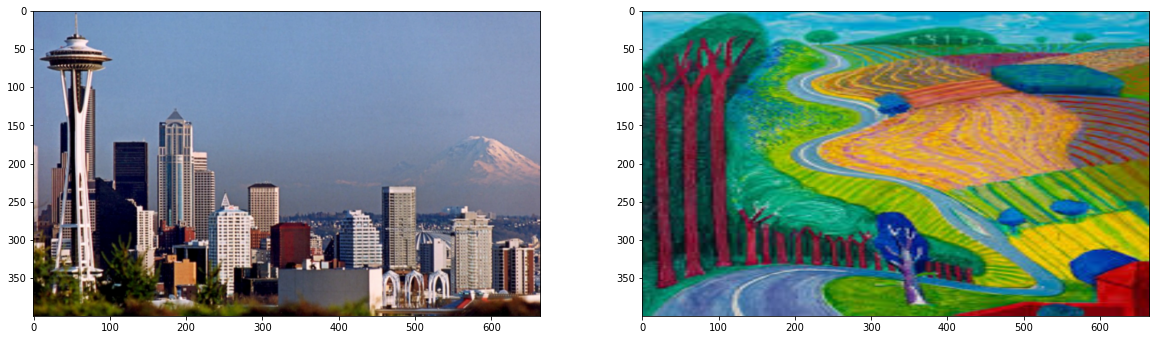

In [9]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(image_convert(content))
ax2.imshow(image_convert(style))

## Gram Matrix
Another fancy linear algebra stuff that seems complex but if we try to understand what it really is nothing but a correlation between the filters of conv layers which is irrespective of size or any rotation.

In [10]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    ## get the batch_size, depth, height, and width of the Tensor
    ## reshape it, so we're multiplying the features for each channel
    ## calculate the gram matrix
    b, d, h, w = tensor.size()
    tensor = tensor.reshape(b*d, h*w)

    gram = torch.mm(tensor, tensor.t())
    return gram 

## Initializing the model

In [11]:
style_model = VGG().to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

## Getting the content and style features from the model

In [29]:
# get content and style features only once before forming the target image
content_features = style_model(content)
style_features = style_model(style)

# calculate the gram matrices for each layer of our style representation
style_grams = [gram_matrix(layer) for layer in style_features]

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [13]:
style_grams[0].shape

torch.Size([64, 64])

In [14]:
target.shape

torch.Size([1, 3, 400, 665])

The style loss function has also some weight which is what we are initializing here.

In [30]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e1  # beta

## Training
Now we will do the training such that target image would be matching more and more close in content to the content image and close in style to style image

Total loss:  13401.013671875


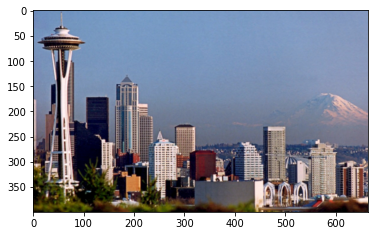

Total loss:  448.00653076171875


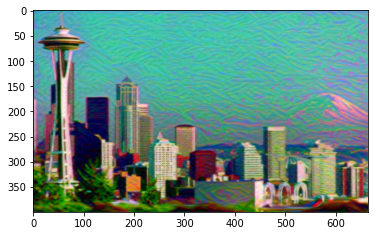

Total loss:  207.42196655273438


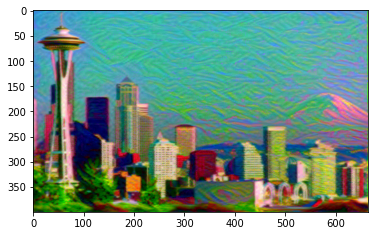

Total loss:  127.2325439453125


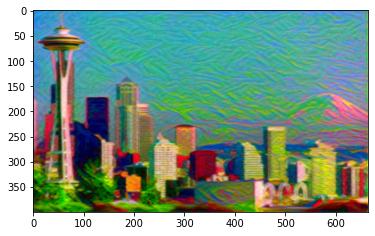

Total loss:  90.69671630859375


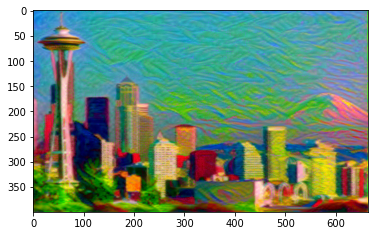

Total loss:  71.88084411621094


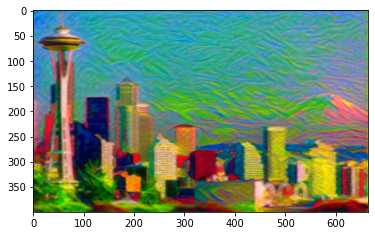

Total loss:  61.82040023803711


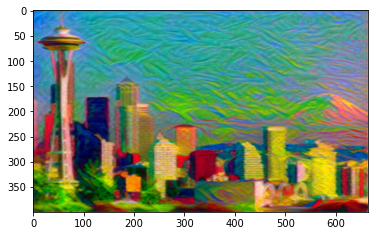

In [31]:
# for displaying the target image, intermittently
show_every =100
# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.007)
steps = 2500  # decide how many iterations to update your image (5000)
plt.imsave('space_street.jpg', image_convert(target))
for ii in range(0, steps+1):
    
    ## TODO: get the features from your target image    
    ## Then calculate the content loss
    style_model.eval()
    target_features = style_model(target)
    content_loss = 0
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    total_loss = None

    # iterate through each style layer and add to the style loss
    for idx,layer in enumerate(style_weights):
        # get the "target" style representation for the layer
        target_feature = target_features[idx]
        _, d, h, w = target_feature.shape
        
        ## target gram matrix
        target_gram = gram_matrix(target_feature)
        
        ## "style" style representation
        style_gram = gram_matrix(style_features[idx])

        ## Calculate the style loss for one layer, weighted appropriately
        ## Layer_style_loss = weights*||target_gram - style_gram||^2
        layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)

        ## Calculate the content loss for each layer
        content_loss += torch.mean((content_features[idx] - target_features[idx])**2)

        # add to the style loss
        # diving by constant 4nm where n = d and m = hxw. The 4 value is ignored
        style_loss += layer_style_loss / (d * h * w)

    ## Total loss = alpha*style_loss + beta*content_loss
    total_loss = style_weight*style_loss + content_weight*content_loss
    ## -- do not need to change code, below -- ##
    # update your target image

    ## Clearing the gradients from previous iters
    optimizer.zero_grad()

    ## Calculating the gradients
    total_loss.backward(retain_graph=True)

    ## Updating the target image
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        plt.imsave('space_street{}.jpg'.format(ii), image_convert(target))
        if(ii % 400 == 0):
            print('Total loss: ', total_loss.item())
            plt.imshow(image_convert(target))
            plt.show()

## Converting the images the images to gif

In [34]:
import imageio
images = []
filenames = []
for i in range(10):
    filenames.append('space_street.jpg')
for i in range(0, 2501, 100):
    filenames.append('space_street{}.jpg'.format(i))
for filename in filenames:
    images.append(imageio.imread('./{}'.format(filename)))

In [35]:
len(images)

36

In [21]:
filenames

['space_street.jpg',
 'space_street0.jpg',
 'space_street100.jpg',
 'space_street200.jpg',
 'space_street300.jpg',
 'space_street400.jpg',
 'space_street500.jpg',
 'space_street600.jpg',
 'space_street700.jpg',
 'space_street800.jpg',
 'space_street900.jpg',
 'space_street1000.jpg',
 'space_street1100.jpg',
 'space_street1200.jpg',
 'space_street1300.jpg',
 'space_street1400.jpg',
 'space_street1500.jpg',
 'space_street1600.jpg',
 'space_street1700.jpg',
 'space_street1800.jpg',
 'space_street1900.jpg',
 'space_street2000.jpg']

In [36]:
imageio.mimsave('./movie.gif', images)